In [1]:
import numpy as np
import cmocean.cm as cmo
import matplotlib.pyplot as plt
import xarray as xr
import xgcm
import gsw
from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec
plt.rcParams['font.size']=14

In [2]:
def fix_dimension(ds, bad_dim, new_dim, trim=True):
    assert len(ds[bad_dim]) == (len(ds[new_dim]) + 1)
    if trim and (len(ds[bad_dim]) == (len(ds[new_dim]) + 1)):
        ds = ds.isel(**{bad_dim: slice(0,-1)})
        assert len(ds[bad_dim]) == len(ds[new_dim])
    swapped_vars = []
    for v in ds:
        # replace naughty dimension
        dims = list(ds[v].dims)
        if bad_dim in dims:
            idx = dims.index(bad_dim)
            dims[idx] = new_dim
            ds[v].variable.dims = dims
            swapped_vars.append(v)
    return ds, swapped_vars

def reset_dimensions(ds, orig_dim, new_dim, *reset_vars):
    for v in reset_vars:
        dims = list(ds[v].dims)
        if new_dim in dims:
            idx = dims.index(new_dim)
            dims[idx] = orig_dim
            ds[v].variable.dims = dims
    # reindexing necessary to figure out new dims
    return ds.reindex()

def open_mncdataset(fname_base, ntiles_y, ntiles_x, iternum=None):
    if iternum is not None:
        itersuf = '.%010d' % iternum
    else:
        itersuf = ''
    dsets_y = []
    for ny in range(ntiles_y):
        dsets_x = []
        swap_vars = set()
        for nx in range(ntiles_x):
            ntile = nx + ntiles_x*ny + 1
            fname = fname_base + '%s.t%03d.nc' % (itersuf, ntile)
            ds = xr.open_dataset(fname)
            ds, swapped_vars_x = fix_dimension(ds, 'Xp1', 'X')    
            ds = ds.chunk()
            dsets_x.append(ds)
        ds_xconcat = xr.concat(dsets_x, 'X')
        ds_xconcat, swapped_vars_y = fix_dimension(ds_xconcat, 'Yp1', 'Y')
        dsets_y.append(ds_xconcat)
    ds = xr.concat(dsets_y, 'Y')
    ds = reset_dimensions(ds, 'Xp1', 'X', *swapped_vars_x)
    ds = reset_dimensions(ds, 'Yp1', 'Y', *swapped_vars_y)
    return ds



In [3]:
# equal t startification
dss = open_mncdataset('run_bump5000_20layers/state', 2, 3, 0)
dsg = open_mncdataset('run_bump5000_20layers/grid', 2, 3, None)
dsb2u=xr.merge((dss,dsg))
dsb2u=dsb2u.isel(Zp1=slice(0,-1))
dsb2u=dsb2u.rename_dims({'Xp1':'X_left','Yp1':'Y_left','Zp1':'Z_left'})
dsb2u = xgcm.generate_grid_ds(dsb2u, {'X':'X', 'Y':'Y', 'Z':'Z'})
dsb2u.coords['day']=dsb2u.T/(24*3600)
dsb2u.coords['month']=dsb2u.day/30

# add meridional gradient to equal stratficiation; thermal wind balanced
dss = open_mncdataset('run_bump5000_20layerswdTdy_tw/state', 2, 3, 0)
dsg = open_mncdataset('run_bump5000_20layerswdTdy_tw/grid', 2, 3, None)
dsb2t=xr.merge((dss,dsg))
dsb2t=dsb2t.isel(Zp1=slice(0,-1))
dsb2t=dsb2t.rename_dims({'Xp1':'X_left','Yp1':'Y_left','Zp1':'Z_left'})
dsb2t = xgcm.generate_grid_ds(dsb2t, {'X':'X', 'Y':'Y', 'Z':'Z'})
dsb2t.coords['day']=dsb2t.T/(24*3600)
dsb2t.coords['month']=dsb2t.day/30

# add to thermal wind a barotropic inflow condition
dss = open_mncdataset('run_bump5000_20layerswdTdy_u01tw/state', 2, 3, 0)
dsg = open_mncdataset('run_bump5000_20layerswdTdy_u01tw//grid', 2, 3, None)
dsb2tu=xr.merge((dss,dsg))
dsb2tu=dsb2tu.isel(Zp1=slice(0,-1))
dsb2tu=dsb2tu.rename_dims({'Xp1':'X_left','Yp1':'Y_left','Zp1':'Z_left'})
dsb2tu=xgcm.generate_grid_ds(dsb2tu, {'X':'X', 'Y':'Y', 'Z':'Z'})
dsb2tu.coords['day']=dsb2tu.T/(24*3600)
dsb2tu.coords['month']=dsb2tu.day/30

# e-scale stratificiation; thermal wind balanced
# equal t startification
dss = open_mncdataset('run_bump5000_20layers_dx5km/state', 10, 15, 0)
dsg = open_mncdataset('run_bump5000_20layers_dx5km/grid', 10, 15, None)
dsb2u_5=xr.merge((dss,dsg))
dsb2u_5=dsb2u_5.isel(Zp1=slice(0,-1))
dsb2u_5=dsb2u_5.rename_dims({'Xp1':'X_left','Yp1':'Y_left','Zp1':'Z_left'})
dsb2u_5 = xgcm.generate_grid_ds(dsb2u_5, {'X':'X', 'Y':'Y', 'Z':'Z'})
dsb2u_5.coords['day']=dsb2u_5.T/(24*3600)
dsb2u_5.coords['month']=dsb2u_5.day/30

# add meridional gradient to equal stratficiation; thermal wind balanced
dss = open_mncdataset('run_bump5000_20layerswdTdy_tw_dx5km/state', 10, 15, 0)
dsg = open_mncdataset('run_bump5000_20layerswdTdy_tw_dx5km/grid', 10, 15, None)
dsb2t_5=xr.merge((dss,dsg))
dsb2t_5=dsb2t_5.isel(Zp1=slice(0,-1))
dsb2t_5=dsb2t_5.rename_dims({'Xp1':'X_left','Yp1':'Y_left','Zp1':'Z_left'})
dsb2t_5 = xgcm.generate_grid_ds(dsb2t_5, {'X':'X', 'Y':'Y', 'Z':'Z'})
dsb2t_5.coords['day']=dsb2t_5.T/(24*3600)
dsb2t_5.coords['month']=dsb2t_5.day/30

# add to thermal wind a barotropic inflow condition
dss = open_mncdataset('run_bump5000_20layerswdTdy_u01tw_dx5km/state', 10, 15, 0)
dsg = open_mncdataset('run_bump5000_20layerswdTdy_u01tw_dx5km/grid', 10, 15, None)
dsb2tu_5=xr.merge((dss,dsg))
dsb2tu_5=dsb2tu_5.isel(Zp1=slice(0,-1))
dsb2tu_5=dsb2tu_5.rename_dims({'Xp1':'X_left','Yp1':'Y_left','Zp1':'Z_left'})
dsb2tu_5=xgcm.generate_grid_ds(dsb2tu_5, {'X':'X', 'Y':'Y', 'Z':'Z'})
dsb2tu_5.coords['day']=dsb2tu_5.T/(24*3600)
dsb2tu_5.coords['month']=dsb2tu_5.day/30

In [4]:
dsb2u['drU']=dsb2u.U.isel(T=0)*0+dsb2u.drF.isel(X=30,Y=20)
dsb2u['drV']=dsb2u.V.isel(T=0)*0+dsb2u.drF.isel(X=30,Y=20)
metrics = {
    ('X',): ['dxC', 'dxG', 'dxV'], # X distances
    ('Y',): ['dyC', 'dyG', 'dyU'], # Y distances
    ('Z',): ['drC', 'drF', 'drU', 'drV'], # Z distances
    }
grid = xgcm.Grid(dsb2u, periodic=False, metrics=metrics)

# Initial conditions

Text(0.5, 1.0, 'Gaussian Bump')

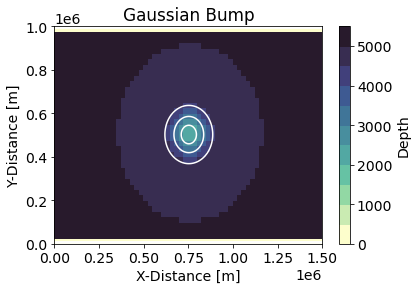

In [5]:
dsb2u.Depth.plot.pcolormesh(x="X",y="Y",vmin=0,vmax=5500,levels=12,cmap=cmo.deep)
dsb2u_5.Depth.plot.contour(x="X",y="Y",levels=[4500,3500,2500],colors='w',add_colorbar=False)
plt.xlabel('X-Distance [m]')
plt.ylabel('Y-Distance [m]')
plt.title('Gaussian Bump')

Text(0.5, 1.0, '20l w m grad - dx=5km')

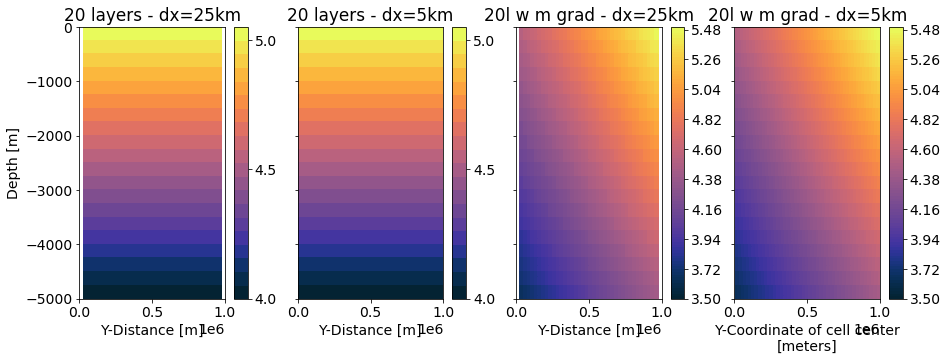

In [6]:
fig = plt.figure(figsize=(15,5))
gs = GridSpec(1,1, width_ratios=[1],wspace=.15)#,wspace=0.3)

gs2 = GridSpecFromSubplotSpec(1,4, subplot_spec=gs[0], width_ratios=[1,1,1,1])

ax3 = fig.add_subplot(gs2[0])#,sharey=ttc_m12)
ax4 = fig.add_subplot(gs2[1])
ax5 = fig.add_subplot(gs2[2])
ax6 = fig.add_subplot(gs2[3])
#ax7 = fig.add_subplot(gs2[4])
# Plot used bathymetries

# Plot used temperature stratification
dsb2u.Temp.where(dsb2u.Temp>0).isel(X=10,T=0).plot.pcolormesh(vmin=4.,vmax=5.05,levels=21,cmap=cmo.thermal,ax=ax3,cbar_kwargs={'label':'','ticks':np.linspace(4,5,3)})#,add_colorbar=False)
dsb2u_5.Temp.where(dsb2u_5.Temp>0).isel(X=10,T=0).plot.pcolormesh(vmin=4.,vmax=5.05,levels=21,cmap=cmo.thermal,ax=ax4,cbar_kwargs={'label':'','ticks':np.linspace(4,5,3)})#,add_colorbar=False)ax=ax4)#,add_colorbar=False)
dsb2t.Temp.where(dsb2t.Temp>0).isel(X=10,T=0).plot.pcolormesh(vmin=3.5,vmax=5.5,levels=101,ax=ax5,cmap=cmo.thermal,cbar_kwargs={'label':''})#,add_colorbar=False)
dsb2t_5.Temp.where(dsb2t_5.Temp>0).isel(X=10,T=0).plot.pcolormesh(vmin=3.5,vmax=5.5,levels=101,cmap=cmo.thermal,ax=ax6,cbar_kwargs={'label':''})#,add_colorbar=False)
#dsb2tu.Temp.where(dsb2tu.Temp>0).isel(X=10,T=0).plot.pcolormesh(vmin=3.5,vmax=5.5,levels=21,cmap=cmo.thermal,ax=ax7,cbar_kwargs={'label':'Temperature [$^\circ\,$C]'})#,add_colorbar=False)
ax3.set_xlabel('Y-Distance [m]')
ax3.set_ylabel('Depth [m]')
#ax3.set_yticklabels('')
ax3.set_title('20 layers - dx=25km')
ax4.set_xlabel('Y-Distance [m]')
ax4.set_ylabel('')
ax4.set_yticklabels('')
ax4.set_title('20 layers - dx=5km')
ax5.set_xlabel('Y-Distance [m]')
ax5.set_ylabel('')
ax5.set_yticklabels('')
ax5.set_title('20l w m grad - dx=25km')
ax6.set_ylabel('')
ax6.set_yticklabels('')
ax6.set_title('20l w m grad - dx=5km')
#ax7.set_ylabel('')
#ax7.set_yticklabels('')
#ax7.set_title('20layers u=0.1+tw')
#plt.savefig('./figures/set_up.png',dpi=300)

## inflow conditions

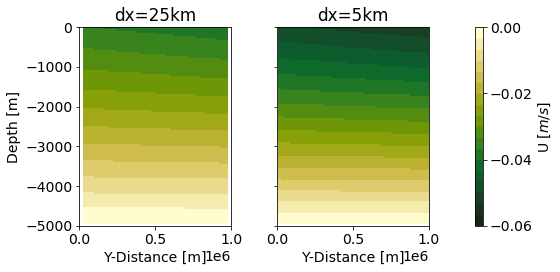

In [7]:

fig,axes=plt.subplots(1,3,figsize=(8,4),gridspec_kw={'width_ratios':[1,1,0.05]})
#
cb=dsb2t.U.isel(T=0,X_left=59).plot.pcolormesh(ax=axes[0],vmin=-.06,vmax=0,levels=19,cmap=cmo.speed_r,add_colorbar=False)          
axes[0].set_title('dx=25km')
axes[0].set_xlabel('Y-Distance [m]')
axes[0].set_ylabel('Depth [m]')

cb=dsb2t_5.U.isel(T=0,X_left=299).plot.pcolormesh(ax=axes[1],vmin=-.06,vmax=0,levels=19,cmap=cmo.speed_r,add_colorbar=False)          
axes[1].set_title('dx=5km')
axes[1].set_xlabel('Y-Distance [m]')
axes[1].set_ylabel('')
axes[1].set_yticklabels('')

plt.colorbar(cb,cax=axes[2],label='U [$m/s$]',ticks=np.linspace(-.08,0,5))
plt.tight_layout()


In [8]:
# Estimate mean u inflow 
print(np.round(dsb2u.U.isel(X_left=59,Y=slice(1,-1),T=0).mean(dim={"Y","Z"}).values,3))
print(np.round(dsb2t.U.isel(X_left=59,Y=slice(1,-1),T=0).mean(dim={"Y","Z"}).values,3))
print(np.round(dsb2tu.U.isel(X_left=59,Y=slice(1,-1),T=0).mean(dim={"Y","Z"}).values,3))
print(np.round(dsb2u_5.U.isel(X_left=299,Y=slice(1,-1),T=0).mean(dim={"Y","Z"}).values,3))
print(np.round(dsb2t_5.U.isel(X_left=299,Y=slice(1,-1),T=0).mean(dim={"Y","Z"}).values,3))
print(np.round(dsb2tu_5.U.isel(X_left=299,Y=slice(1,-1),T=0).mean(dim={"Y","Z"}).values,3))

-0.1
-0.02
-0.12
-0.1
-0.027
-0.127


# Analysis

[Text(0, 0.0, ''),
 Text(0, 200000.0, ''),
 Text(0, 400000.0, ''),
 Text(0, 600000.0, ''),
 Text(0, 800000.0, ''),
 Text(0, 1000000.0, '')]

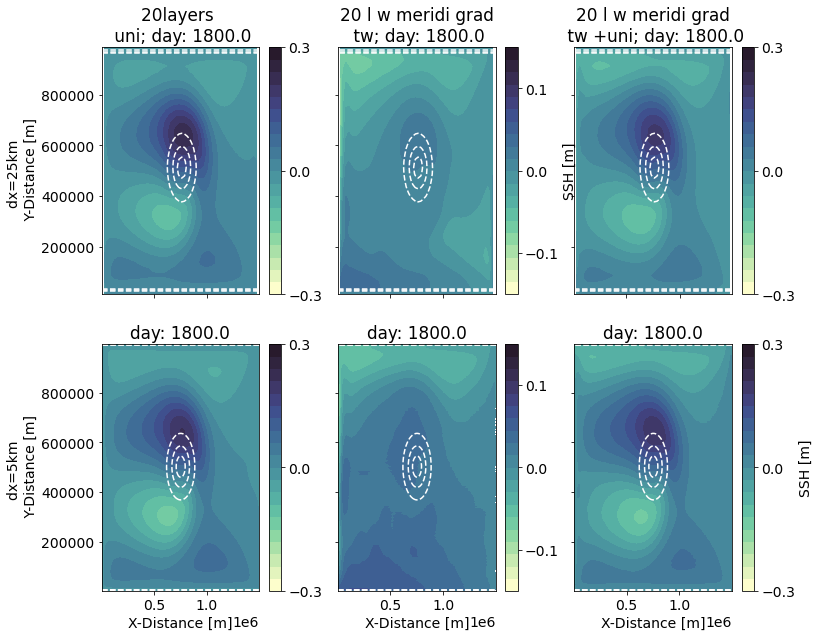

In [9]:
#plot SSH at last time step
t=60
arr=3
wmin=-.3
wmax=-1*wmin
cmap2=cmo.deep
lev=21

fig,axes=plt.subplots(2,3,figsize=(12,10))
ax=axes[0,0]
(dsb2u.Eta.isel(T=t)-dsb2u.Eta.isel(T=-1,X=58)).isel(X=slice(1,59)).plot.contourf(cmap=cmap2,vmin=wmin,vmax=wmax,levels=lev,ax=ax,cbar_kwargs={'label':'','ticks':np.linspace(-.3,.3,3)})
dsb2u.Depth.plot.contour(levels=[2500,3500,4500],ax=ax,linestyles='--',colors='w')
ax.set_title(f'20layers \n uni; day: {dsb2u.day.isel(T=t).values}')
ax.set_xlabel('')
ax.set_ylabel('dx=25km \n Y-Distance [m]')
ax.set_xticklabels('')

ax=axes[0,1]
(dsb2t.Eta.isel(T=t)-dsb2t.Eta.isel(T=-1,X=58)).isel(X=slice(1,59)).plot.contourf(cmap=cmap2,vmin=wmin*.5,vmax=wmax*.5,levels=lev,ax=ax,cbar_kwargs={'label':'SSH [m]','ticks':np.linspace(-.1,.1,3)})
dsb2t.Depth.plot.contour(levels=[2500,3500,4500],ax=ax,linestyles='--',colors='w')
ax.set_title(f'20 l w meridi grad\n tw; day: {dsb2t.day.isel(T=t).values}')
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_yticklabels('')
ax.set_xticklabels('')

ax=axes[0,2]
(dsb2tu.Eta.isel(T=t)-dsb2tu.Eta.isel(T=-1,X=58)).isel(X=slice(1,59)).plot.contourf(cmap=cmap2,vmin=wmin,vmax=wmax,levels=lev,ax=ax,cbar_kwargs={'label':'','ticks':np.linspace(-.3,.3,3)})
dsb2tu.Depth.plot.contour(levels=[2500,3500,4500],ax=ax,linestyles='--',colors='w')
ax.set_title(f'20 l w meridi grad\n tw +uni; day: {dsb2tu.day.isel(T=t).values}')
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_yticklabels('')
ax.set_xticklabels('')

ax=axes[1,0]
(dsb2u_5.Eta.isel(T=t)-dsb2u_5.Eta.isel(T=-1,X=298)).isel(X=slice(1,299)).plot.contourf(cmap=cmap2,vmin=wmin,vmax=wmax,levels=lev,ax=ax,cbar_kwargs={'label':'','ticks':np.linspace(-.3,.3,3)})
dsb2u_5.Depth.plot.contour(levels=[2500,3500,4500],ax=ax,linestyles='--',colors='w')
ax.set_title(f'day: {dsb2u_5.day.isel(T=t).values}')
ax.set_xlabel('X-Distance [m]')
ax.set_ylabel('dx=5km \n Y-Distance [m]')
#ax.set_yticklabels('')

ax=axes[1,1]
(dsb2t_5.Eta.isel(T=t)-dsb2t_5.Eta.isel(T=-1,X=298)).isel(X=slice(1,299)).plot.contourf(cmap=cmap2,vmin=wmin*.5,vmax=wmax*.5,levels=lev,ax=ax,cbar_kwargs={'label':'','ticks':np.linspace(-.1,.1,3)})
dsb2t_5.Depth.plot.contour(levels=[2500,3500,4500],ax=ax,linestyles='--',colors='w')
ax.set_title(f'day: {dsb2t_5.day.isel(T=t).values}')
ax.set_xlabel('X-Distance [m]')
ax.set_ylabel('')
ax.set_yticklabels('')


ax=axes[1,2]
(dsb2tu_5.Eta.isel(T=t)-dsb2tu_5.Eta.isel(T=-1,X=298)).isel(X=slice(1,299)).plot.contourf(cmap=cmap2,vmin=wmin,vmax=wmax,levels=lev,ax=ax,cbar_kwargs={'label':'SSH [m]','ticks':np.linspace(-.3,.3,3)})
dsb2tu_5.Depth.plot.contour(levels=[2500,3500,4500],ax=ax,linestyles='--',colors='w')
ax.set_title(f'20 l w meridi grad\n tw +uni; day: {dsb2tu_5.day.isel(T=t).values}')
ax.set_title(f'day: {dsb2tu_5.day.isel(T=t).values}')
ax.set_xlabel('X-Distance [m]')
ax.set_ylabel('')
ax.set_yticklabels('')

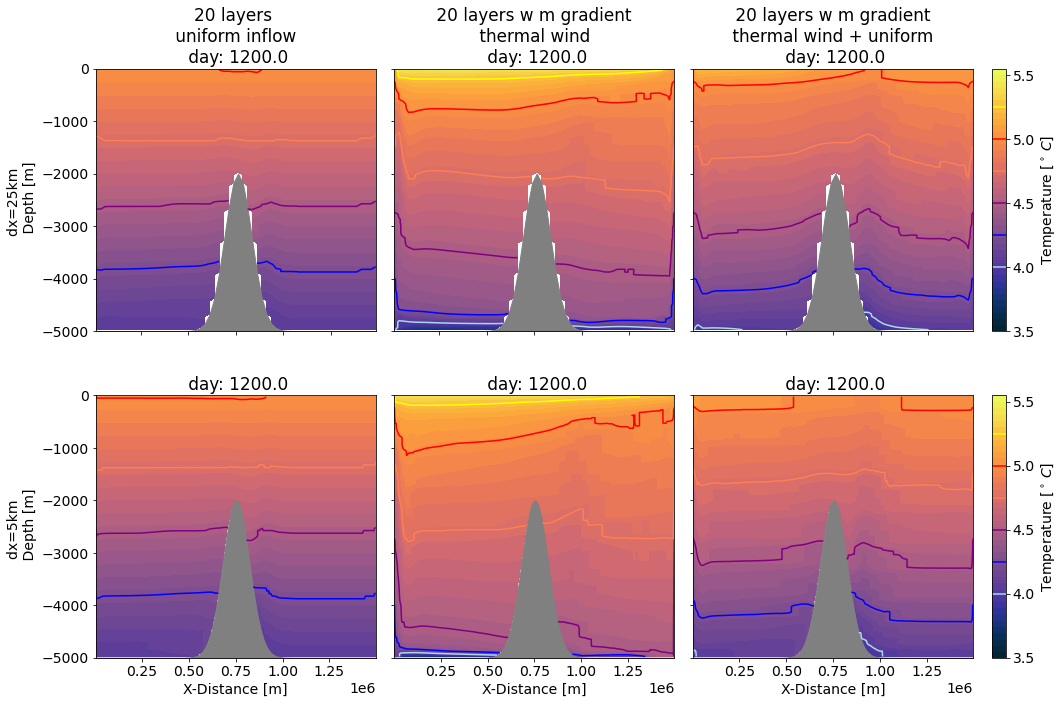

In [10]:
#plot T section  for 20 layer cases
t=40
wmin=3.5
wmax=5.55
cmap2=cmo.thermal
lev=43

fig,axes=plt.subplots(2,4,figsize=(15,10),gridspec_kw={'width_ratios':[1,1,1,0.05]})


ax=axes[0,0]
dsb2u.Temp.where(dsb2u.Temp>0).isel(T=t,Y=20).plot.contourf(cmap=cmap2,vmin=wmin,vmax=wmax,levels=lev,ax=ax,add_colorbar=False)
ax.fill_between(dsb2u.X,(-1*dsb2u.Depth).isel(Y=20),-5000,color='grey')
dsb2u.Temp.where(dsb2u.Temp>0).isel(T=t,Y=20).plot.contour(ax=ax,colors=['lightblue','b','purple','coral','r','yellow'],levels=[4.0,4.25,4.5,4.75,5,5.25])
ax.set_title(f'20 layers \n uniform inflow \n day: {dsb2u.day.isel(T=t).values}')
ax.set_xlabel('')
ax.set_xticklabels('')
ax.set_ylabel('dx=25km \n Depth [m]')
ax.set_ylim((-5000,0))

ax=axes[0,1]
cb=(dsb2t.Temp.where(dsb2t.Temp>0).isel(T=t,Y=20)).plot.contourf(cmap=cmap2,vmin=wmin,vmax=wmax,levels=lev,ax=ax,add_colorbar=False)
dsb2t.Temp.where(dsb2t.Temp>0).isel(T=t,Y=20).plot.contour(ax=ax,colors=['lightblue','b','purple','coral','r','yellow'],levels=[4.0,4.25,4.5,4.75,5,5.25])
ax.fill_between(dsb2t.X,(-1*dsb2t.Depth).isel(Y=20),-5000,color='grey')
ax.set_title(f' 20 layers w m gradient \n thermal wind \n day: {dsb2t.day.isel(T=t).values}')
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_xticklabels('')
ax.set_ylim((-5000,0))
ax.set_yticklabels('')

ax=axes[0,2]
cb=(dsb2tu.Temp.where(dsb2tu.Temp>0).isel(T=t,Y=20)).plot.contourf(cmap=cmap2,vmin=wmin,vmax=wmax,levels=lev,ax=ax,add_colorbar=False)
cctt=dsb2tu.Temp.where(dsb2tu.Temp>0).isel(T=t,Y=20).plot.contour(ax=ax,colors=['lightblue','b','purple','coral','r','yellow'],levels=[4.0,4.25,4.5,4.75,5,5.25])
ax.fill_between(dsb2tu.X,(-1*dsb2tu.Depth).isel(Y=20),-5000,color='grey')

ax.set_title(f' 20 layers w m gradient \n thermal wind + uniform \n day: {dsb2tu.day.isel(T=t).values}')
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_xticklabels('')
ax.set_ylim((-5000,0))
ax.set_yticklabels('')

cbar=plt.colorbar(cb,cax=axes[0,3],label='Temperature [$^\circ\,C$]',ticks=np.linspace(3.5,5.5,5))
cbar.add_lines(cctt)
ax=axes[1,0]
dsb2u_5.Temp.where(dsb2u_5.Temp>0).isel(T=t,Y=100).plot.contourf(cmap=cmap2,vmin=wmin,vmax=wmax,levels=lev,ax=ax,add_colorbar=False)
ax.fill_between(dsb2u_5.X,(-1*dsb2u_5.Depth).isel(Y=100),-5000,color='grey')
dsb2u_5.Temp.where(dsb2u_5.Temp>0).isel(T=t,Y=100).plot.contour(ax=ax,colors=['lightblue','b','purple','coral','r','yellow'],levels=[4.0,4.25,4.5,4.75,5,5.25])
ax.set_title(f'\n day: {dsb2u_5.day.isel(T=t).values}')
ax.set_xlabel('X-Distance [m]')
ax.set_ylabel('dx=5km \n Depth [m]')
ax.set_ylim((-5000,0))

ax=axes[1,1]
cb=(dsb2t_5.Temp.where(dsb2t_5.Temp>0).isel(T=t,Y=100)).plot.contourf(cmap=cmap2,vmin=wmin,vmax=wmax,levels=lev,ax=ax,add_colorbar=False)
dsb2t_5.Temp.where(dsb2t_5.Temp>0).isel(T=t,Y=100).plot.contour(ax=ax,colors=['lightblue','b','purple','coral','r','yellow'],levels=[4.0,4.25,4.5,4.75,5,5.25])
ax.fill_between(dsb2t_5.X,(-1*dsb2t_5.Depth).isel(Y=100),-5000,color='grey')
ax.set_title(f' \n day: {dsb2t_5.day.isel(T=t).values}')
ax.set_xlabel('X-Distance [m]')
ax.set_ylabel('')
ax.set_ylim((-5000,0))
ax.set_yticklabels('')

ax=axes[1,2]
cb5=(dsb2tu_5.Temp.where(dsb2tu_5.Temp>0).isel(T=t,Y=100)).plot.contourf(cmap=cmap2,vmin=wmin,vmax=wmax,levels=lev,ax=ax,add_colorbar=False)
cctt=dsb2tu_5.Temp.where(dsb2tu_5.Temp>0).isel(T=t,Y=100).plot.contour(ax=ax,colors=['lightblue','b','purple','coral','r','yellow'],levels=[4.0,4.25,4.5,4.75,5,5.25])
ax.fill_between(dsb2tu_5.X,(-1*dsb2tu_5.Depth).isel(Y=100),-5000,color='grey')

ax.set_title(f'  \n day: {dsb2tu_5.day.isel(T=t).values}')
ax.set_xlabel('X-Distance [m]')
ax.set_ylabel('')
ax.set_ylim((-5000,0))
ax.set_yticklabels('')

cbar=plt.colorbar(cb5,cax=axes[1,3],label='Temperature [$^\circ\,C$]',ticks=np.linspace(3.5,5.5,5))
cbar.add_lines(cctt)
plt.tight_layout()

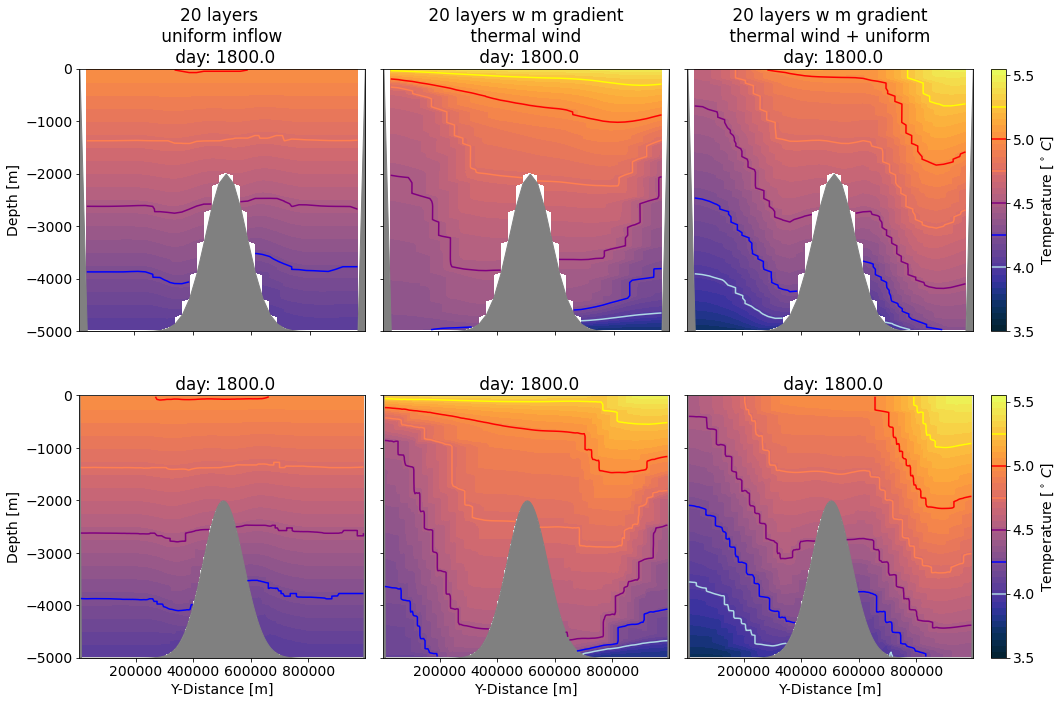

In [11]:
#plot T section along Y  for 20 layer cases
t=60
arr=3
wmin=3.5
wmax=5.55
cmap2=cmo.thermal
lev=43

fig,axes=plt.subplots(2,4,figsize=(15,10),gridspec_kw={'width_ratios':[1,1,1,0.05]})


ax=axes[0,0]
dsb2u.Temp.where(dsb2u.Temp>0).isel(T=t,X=30).plot.contourf(cmap=cmap2,vmin=wmin,vmax=wmax,levels=lev,ax=ax,add_colorbar=False)
ax.fill_between(dsb2u.Y,(-1*dsb2u.Depth).isel(X=30),-5000,color='grey')
dsb2u.Temp.where(dsb2u.Temp>0).isel(T=t,X=30).plot.contour(ax=ax,colors=['lightblue','b','purple','coral','r','yellow'],levels=[4.0,4.25,4.5,4.75,5,5.25])
ax.set_title(f'20 layers \n uniform inflow \n day: {dsb2u.day.isel(T=t).values}')
ax.set_xlabel('')
ax.set_xticklabels('')
ax.set_ylabel('Depth [m]')
ax.set_ylim((-5000,0))

ax=axes[0,1]
cb=(dsb2t.Temp.where(dsb2t.Temp>0).isel(T=t,X=30)).plot.contourf(cmap=cmap2,vmin=wmin,vmax=wmax,levels=lev,ax=ax,add_colorbar=False)
dsb2t.Temp.where(dsb2t.Temp>0).isel(T=t,X=30).plot.contour(ax=ax,colors=['lightblue','b','purple','coral','r','yellow'],levels=[4.0,4.25,4.5,4.75,5,5.25])
ax.fill_between(dsb2t.Y,(-1*dsb2t.Depth).isel(X=30),-5000,color='grey')
ax.set_title(f' 20 layers w m gradient \n thermal wind \n day: {dsb2t.day.isel(T=t).values}')
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_xticklabels('')
ax.set_ylim((-5000,0))
ax.set_yticklabels('')

ax=axes[0,2]
cb=(dsb2tu.Temp.where(dsb2tu.Temp>0).isel(T=t,X=30)).plot.contourf(cmap=cmap2,vmin=wmin,vmax=wmax,levels=lev,ax=ax,add_colorbar=False)
cctt=dsb2tu.Temp.where(dsb2tu.Temp>0).isel(T=t,X=30).plot.contour(ax=ax,colors=['lightblue','b','purple','coral','r','yellow'],levels=[4.0,4.25,4.5,4.75,5,5.25])
ax.fill_between(dsb2tu.Y,(-1*dsb2tu.Depth).isel(X=30),-5000,color='grey')

ax.set_title(f' 20 layers w m gradient \n thermal wind + uniform \n day: {dsb2tu.day.isel(T=t).values}')
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_xticklabels('')
ax.set_ylim((-5000,0))
ax.set_yticklabels('')

cbar=plt.colorbar(cb,cax=axes[0,3],label='Temperature [$^\circ\,C$]',ticks=np.linspace(3.5,5.5,5))
cbar.add_lines(cctt)
ax=axes[1,0]
dsb2u_5.Temp.where(dsb2u_5.Temp>0).isel(T=t,X=150).plot.contourf(cmap=cmap2,vmin=wmin,vmax=wmax,levels=lev,ax=ax,add_colorbar=False)
ax.fill_between(dsb2u_5.Y,(-1*dsb2u_5.Depth).isel(X=150),-5000,color='grey')
dsb2u_5.Temp.where(dsb2u_5.Temp>0).isel(T=t,X=150).plot.contour(ax=ax,colors=['lightblue','b','purple','coral','r','yellow'],levels=[4.0,4.25,4.5,4.75,5,5.25])
ax.set_title(f'\n day: {dsb2u_5.day.isel(T=t).values}')
ax.set_xlabel('Y-Distance [m]')
ax.set_ylabel('Depth [m]')
ax.set_ylim((-5000,0))

ax=axes[1,1]
cb=(dsb2t_5.Temp.where(dsb2t_5.Temp>0).isel(T=t,X=150)).plot.contourf(cmap=cmap2,vmin=wmin,vmax=wmax,levels=lev,ax=ax,add_colorbar=False)
dsb2t_5.Temp.where(dsb2t_5.Temp>0).isel(T=t,X=150).plot.contour(ax=ax,colors=['lightblue','b','purple','coral','r','yellow'],levels=[4.0,4.25,4.5,4.75,5,5.25])
ax.fill_between(dsb2t_5.Y,(-1*dsb2t_5.Depth).isel(X=150),-5000,color='grey')
ax.set_title(f' \n day: {dsb2t_5.day.isel(T=t).values}')
ax.set_xlabel('Y-Distance [m]')
ax.set_ylabel('')
ax.set_ylim((-5000,0))
ax.set_yticklabels('')

ax=axes[1,2]
cb5=(dsb2tu_5.Temp.where(dsb2tu_5.Temp>0).isel(T=t,X=150)).plot.contourf(cmap=cmap2,vmin=wmin,vmax=wmax,levels=lev,ax=ax,add_colorbar=False)
cctt=dsb2tu_5.Temp.where(dsb2tu_5.Temp>0).isel(T=t,X=150).plot.contour(ax=ax,colors=['lightblue','b','purple','coral','r','yellow'],levels=[4.0,4.25,4.5,4.75,5,5.25])
ax.fill_between(dsb2tu_5.Y,(-1*dsb2tu_5.Depth).isel(X=150),-5000,color='grey')

ax.set_title(f'  \n day: {dsb2tu_5.day.isel(T=t).values}')
ax.set_xlabel('Y-Distance [m]')
ax.set_ylabel('')
ax.set_ylim((-5000,0))
ax.set_yticklabels('')

cbar=plt.colorbar(cb5,cax=axes[1,3],label='Temperature [$^\circ\,C$]',ticks=np.linspace(3.5,5.5,5))
cbar.add_lines(cctt)
plt.tight_layout()

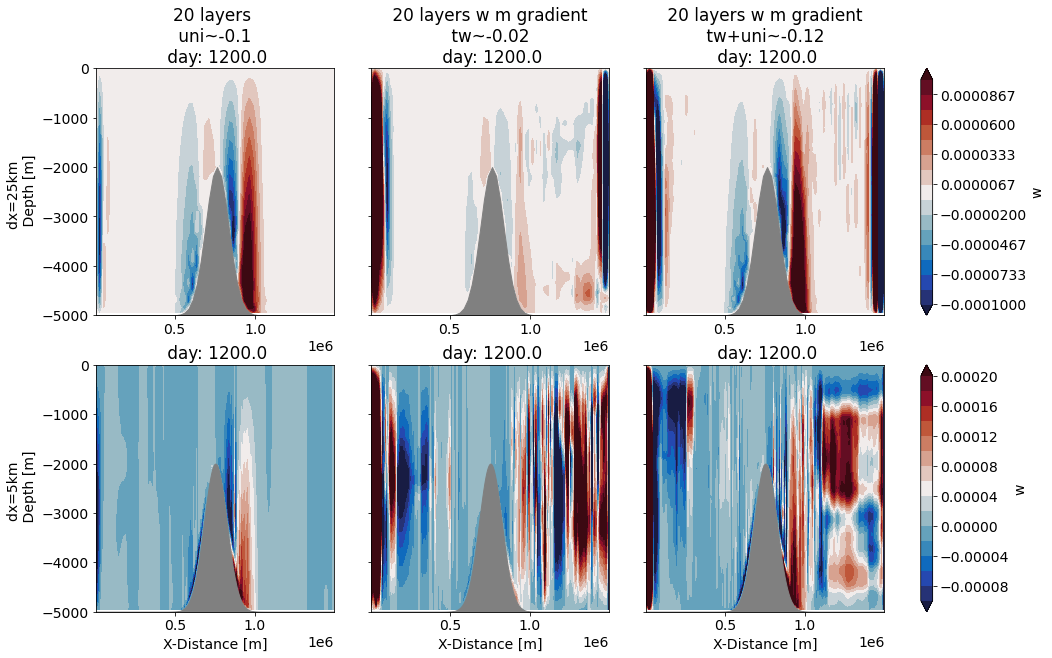

In [19]:
#plot T section  for 20 layer cases
t=40
arr=3
wmin=-0.0001
wmax=0.0001
cmap2=cmo.balance
lev=16

fig,axes=plt.subplots(2,4,figsize=(15,10),gridspec_kw={'width_ratios':[1,1,1,0.05]})


ax=axes[0,0]
dsb2u.W.isel(T=t,Y=20).plot.contourf(cmap=cmap2,vmin=wmin,vmax=wmax,levels=lev,ax=ax,add_colorbar=False)
ax.fill_between(dsb2u.X,(-1*dsb2u.Depth).isel(Y=20),-5000,color='grey')
#dsb2u.Temp.where(dsb2u.Temp>0).isel(T=t,Y=20).plot.contour(ax=ax,colors=['lightblue','b','purple','coral','r','yellow'],levels=[4.0,4.25,4.5,4.75,5,5.25])
ax.set_title(f'20 layers \n uni~-0.1 \n day: {dsb2u.day.isel(T=t).values}')
ax.set_xlabel('')
ax.set_ylabel('dx=25km \n Depth [m]')
ax.set_ylim((-5000,0))

ax=axes[0,1]
cb=(dsb2t.W.isel(T=t,Y=20)).plot.contourf(cmap=cmap2,vmin=wmin,vmax=wmax,levels=lev,ax=ax,add_colorbar=False)
#dsb2t.Temp.where(dsb2t.Temp>0).isel(T=t,Y=20).plot.contour(ax=ax,colors=['lightblue','b','purple','coral','r','yellow'],levels=[4.0,4.25,4.5,4.75,5,5.25])
ax.fill_between(dsb2t.X,(-1*dsb2t.Depth).isel(Y=20),-5000,color='grey')
ax.set_title(f' 20 layers w m gradient \n tw~-0.02 \n day: {dsb2t.day.isel(T=t).values}')
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_ylim((-5000,0))
ax.set_yticklabels('')

ax=axes[0,2]
cb=(dsb2tu.W.isel(T=t,Y=20)).plot.contourf(cmap=cmap2,vmin=wmin,vmax=wmax,levels=lev,ax=ax,add_colorbar=False)
#cctt=dsb2tu.Temp.where(dsb2tu.Temp>0).isel(T=t,Y=20).plot.contour(ax=ax,colors=['lightblue','b','purple','coral','r','yellow'],levels=[4.0,4.25,4.5,4.75,5,5.25])
ax.fill_between(dsb2tu.X,(-1*dsb2tu.Depth).isel(Y=20),-5000,color='grey')

ax.set_title(f' 20 layers w m gradient \n tw+uni~-0.12 \n day: {dsb2tu.day.isel(T=t).values}')
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_ylim((-5000,0))
ax.set_yticklabels('')

cbar=plt.colorbar(cb,cax=axes[0,3],label='w')


ax=axes[1,0]
dsb2u_5.W.isel(T=t,Y=100).plot.contourf(cmap=cmap2,vmin=wmin,vmax=wmax*2,levels=lev,ax=ax,add_colorbar=False)
ax.fill_between(dsb2u_5.X,(-1*dsb2u_5.Depth).isel(Y=100),-5000,color='grey')
ax.set_title(f'\n day: {dsb2u_5.day.isel(T=t).values}')
ax.set_xlabel('X-Distance [m]')
ax.set_ylabel('dx=5km \n Depth [m]')
ax.set_ylim((-5000,0))

ax=axes[1,1]
(dsb2t_5.W.isel(T=t,Y=100)).plot.contourf(cmap=cmap2,vmin=wmin,vmax=wmax*2,levels=lev,ax=ax,add_colorbar=False)
ax.fill_between(dsb2t_5.X,(-1*dsb2t_5.Depth).isel(Y=100),-5000,color='grey')
ax.set_title(f' \n day: {dsb2t_5.day.isel(T=t).values}')
ax.set_xlabel('X-Distance [m]')
ax.set_ylabel('')
ax.set_ylim((-5000,0))
ax.set_yticklabels('')

ax=axes[1,2]
cb5=(dsb2tu_5.W.isel(T=t,Y=100)).plot.contourf(cmap=cmap2,vmin=wmin,vmax=wmax*2,levels=lev,ax=ax,add_colorbar=False)
ax.fill_between(dsb2tu_5.X,(-1*dsb2tu_5.Depth).isel(Y=100),-5000,color='grey')

ax.set_title(f'  \n day: {dsb2tu_5.day.isel(T=t).values}')
ax.set_xlabel('X-Distance [m]')
ax.set_ylabel('')
ax.set_ylim((-5000,0))
ax.set_yticklabels('')

cbar=plt.colorbar(cb5,cax=axes[1,3],label='w')